In [1]:
# import required packages

from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from queue import PriorityQueue
from IPython.display import Markdown, display
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import pyLDAvis
import spacy
import re
import json

%matplotlib inline

In [2]:
# to print text in bold/italics
def printmd(string):
    display(Markdown(string))

#### Steps for developing the Profile Recommender

- Preprocess tweet text: remove stopwords, lemmatize etc.
- Extract optimal number of topics and apply Latent Dirichlet Allocation.
- Using the LDA model, obtain topic scores for each document, which are nothing but probability distributions.
- Apply K-Means on the N-dimensional vectors where N is the optimal number of topics.
- For making a recommendation given a tweet document, first obtain its probability distribution from the trained LDA model. Identify the obtained vector's cluster, and find the 5 closest data points in the same cluster. Display them as recommendations.

### Data Manipulation

In [3]:
# load the raw tweet text alongwith the usernames

df_tweets_raw = pd.read_csv("tweets_730k.csv", encoding="utf-8")
df_tweets_raw.rename(columns={"text": "raw_text"}, inplace=True)
df_tweets_raw = df_tweets_raw[["username", "raw_text"]]
print(df_tweets_raw.shape)
df_tweets_raw.head()

(730000, 2)


,username,raw_text
0,1mikestreet1,Trump’s war on critical race theory is maybe t...
1,mulliganpete,Typical Sarah Sanders dodging questions. This ...
2,Tom26058303,"Rumble — In this episode, I address the explos..."
3,adiinvincible25,The US “liberal” media is a JOKE. Loonies goin...
4,Surya29011996,Covid-19 Report For 22nd September\n\nNew Posi...


In [4]:
# load the partially-cleaned version, and map it to the original text, so that it can be displayed as recommendations

df_tweets = pd.read_csv("tweets_emoticons_processed.csv")
df_tweets = df_tweets[["username", "text"]]
df_tweets["raw_text"] = df_tweets_raw["raw_text"]
print(df_tweets.shape)
df_tweets.head()

(730000, 3)


,username,text,raw_text
0,1mikestreet1,trumps war on critical race theory is maybe th...,Trump’s war on critical race theory is maybe t...
1,mulliganpete,typical sarah sanders dodging questions this r...,Typical Sarah Sanders dodging questions. This ...
2,Tom26058303,rumble in this episode i address the explosive...,"Rumble — In this episode, I address the explos..."
3,adiinvincible25,the us liberal media is a joke loonies going g...,The US “liberal” media is a JOKE. Loonies goin...
4,Surya29011996,covid19 report for 22nd september new positive...,Covid-19 Report For 22nd September\n\nNew Posi...


In [5]:
# concatenate tweets by the same users using whitespace, considering each as a "tweet document"

df_tweets["concat_text"] = df_tweets[['username','text']].groupby('username')['text'].transform(lambda x: ' '.join(x))
df_tweets["concat_raw_text"] = df_tweets[['username','raw_text']].groupby('username')['raw_text'].transform(lambda x: '\n'.join(x))
df_tweets_grouped = df_tweets[["username", "concat_text", "concat_raw_text"]].drop_duplicates()

print(df_tweets_grouped.shape)
df_tweets_grouped.head()

(483228, 3)


,username,concat_text,concat_raw_text
0,1mikestreet1,trumps war on critical race theory is maybe th...,Trump’s war on critical race theory is maybe t...
1,mulliganpete,typical sarah sanders dodging questions this r...,Typical Sarah Sanders dodging questions. This ...
2,Tom26058303,rumble in this episode i address the explosive...,"Rumble — In this episode, I address the explos..."
3,adiinvincible25,the us liberal media is a joke loonies going g...,The US “liberal” media is a JOKE. Loonies goin...
4,Surya29011996,covid19 report for 22nd september new positive...,Covid-19 Report For 22nd September\n\nNew Posi...


In [6]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags={'NOUN', 'ADJ'}):
    """
    This function is used for lemmatizing the tweet text.
    
    Args:
    texts (list): list of lists, each nested list contains tokens in a tweet document
    allowed_postags (set): set of POS to keep, and discard the rest
    
    Returns:
    texts_out (list): list of lists, each nested list containing lemmatized versions of the allowed POS tags
    """
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if (token.pos_ in allowed_postags) and len(token)>1])
    return texts_out

def remove_stopwords(text):
    """
    This function removes stopwords and stray whitespaces from the text.
    
    Args:
    text (str): tweet text
    
    Returns:
    text (str): cleaned text
    """
    
    text = text.lower()
    text = " ".join([word for word in text.split(" ") if word not in STOPWORDS])
    text = "".join([ch for ch in text if ch.isalpha() or ch.isdigit() or ch == " "])
    text = re.sub(" +", " ", text)
    return text


In [7]:
# apply the function for removing stopwords
df_tweets_grouped["concat_text"] = df_tweets_grouped["concat_text"].apply(remove_stopwords)

print(df_tweets_grouped.shape)
df_tweets_grouped.head()

(483228, 3)


,username,concat_text,concat_raw_text
0,1mikestreet1,trumps war critical race theory maybe importan...,Trump’s war on critical race theory is maybe t...
1,mulliganpete,typical sarah sanders dodging questions report...,Typical Sarah Sanders dodging questions. This ...
2,Tom26058303,rumble episode address explosive ties billiona...,"Rumble — In this episode, I address the explos..."
3,adiinvincible25,liberal media joke loonies going gaga xi jinpi...,The US “liberal” media is a JOKE. Loonies goin...
4,Surya29011996,covid19 report 22nd september new positive cas...,Covid-19 Report For 22nd September\n\nNew Posi...


In [8]:
# Extract token list for each tweet document
df_tweets_grouped["tokens"] = df_tweets_grouped["concat_text"].apply(lambda x: x.split(" "))
data_words = df_tweets_grouped["tokens"].to_list()
data_words[:1]

[['trumps',
  'war',
  'critical',
  'race',
  'theory',
  'maybe',
  'important',
  'thing',
  'presidency',
  'banned',
  'schools',
  'elementary',
  'universities',
  'leftist',
  'race',
  'hustlers',
  'brainwashing',
  'kids',
  'madness',
  'long',
  'actually',
  'democrats',
  'accept',
  'outcome',
  '2020',
  'election',
  'accept',
  'outcome',
  '2016',
  'election',
  'httpstcopzryhahrlj']]

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['trumps', 'war_critical_race', 'theory', 'maybe', 'important', 'thing_presidency_banned', 'schools_elementary_universities_leftist', 'race_hustlers_brainwashing_kids', 'madness', 'long', 'actually', 'democrats', 'accept_outcome', '2020', 'election', 'accept_outcome_2016', 'election', 'httpstcopzryhahrlj']


In [10]:
def make_bigrams(texts):
    """
    Makes bigrams for the tweet documents. If two words occur together frequently, they form a bigram
    by concatenating them with an underscore.
    
    Args:
    texts (list): list of lists, each nested list containing tokens from each tweet document
    
    Returns:
    list of lists, each nested list containing tokens in each tweet document, which also include bigrams
    if they exist
    """
    
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    """
    Makes trigrams for the tweet documents. If three words occur together frequently, they form a trigram
    by concatenating them with an underscore.
    
    Args:
    texts (list): list of lists, each nested list containing tokens from each tweet document
    
    Returns:
    list of lists, each nested list containing tokens in each tweet document, which also include trigrams
    if they exist
    """
    
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [11]:
# preview of bigrams
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams[0]

['trumps',
 'war',
 'critical_race',
 'theory',
 'maybe',
 'important',
 'thing',
 'presidency_banned',
 'schools_elementary',
 'universities_leftist',
 'race_hustlers',
 'brainwashing_kids',
 'madness',
 'long',
 'actually',
 'democrats',
 'accept_outcome',
 '2020',
 'election',
 'accept_outcome',
 '2016',
 'election',
 'httpstcopzryhahrlj']

In [12]:
# preview of trigrams
data_words_trigrams = make_trigrams(data_words)
data_words_trigrams[0]

['trumps',
 'war_critical_race',
 'theory',
 'maybe',
 'important',
 'thing_presidency_banned',
 'schools_elementary_universities_leftist',
 'race_hustlers_brainwashing_kids',
 'madness',
 'long',
 'actually',
 'democrats',
 'accept_outcome',
 '2020',
 'election',
 'accept_outcome_2016',
 'election',
 'httpstcopzryhahrlj']

In [34]:
# preview of lemmatized tokens
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags={'NOUN', 'ADJ'})
data_lemmatized[0]

['war',
 'critical_race',
 'theory',
 'important',
 'thing',
 'schools_elementary',
 'universities_leftist',
 'race_hustler',
 'brainwashing_kid',
 'accept_outcome',
 'election',
 'accept_outcome',
 'election']

In [35]:
len(data_lemmatized)

483228

### Apply Latent Dirichlet Allocation (LDA)

In [36]:
# build a dictionary from the pre-processed tokens and form a doc-term matrix
dictionary = gensim.corpora.Dictionary(data_lemmatized)
doc_term_matrix = [dictionary.doc2bow(token_list) for token_list in data_lemmatized]

In [37]:
# vocabulary of the unique tokens in the data
print(dictionary)

Dictionary(123138 unique tokens: ['accept_outcome', 'brainwashing_kid', 'critical_race', 'election', 'important']...)


In [38]:
# doc-term matrix
print(doc_term_matrix[0])

[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


#### Find Optimal Number of Topics

In [18]:
coherence_values = []
model_list = []
# Build LDA model
LDA = gensim.models.LdaMulticore
for k in tqdm(range(4, 31)):
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=k, random_state=100,
                    passes=10, workers=3) # iterations=50
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
#     print("\nNumber of topics: ", k)
#     print('Coherence Score: ', coherence_lda)
    model_list.append(model_list)
    coherence_values.append(coherence_lda)

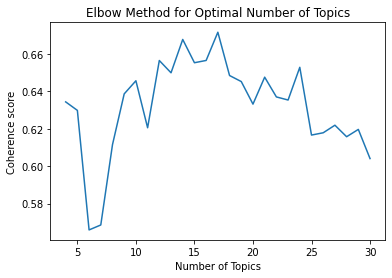

In [19]:
plt.plot(list(range(4, 31)), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Elbow Method for Optimal Number of Topics")
plt.savefig("topic_model_elbow.png")

### Apply LDA with the optimal number of topics

In [39]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10,
                random_state=5,
                passes=10,
                workers=3,
                per_word_topics=True) # iterations=50


In [40]:
# print top words in each topic
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.218*"vote" + 0.047*"voting" + 0.032*"year" + 0.020*"time" + 0.017*"peoples_choice" + 0.013*"let" + 0.013*"retweet" + 0.011*"ready" + 0.010*"end" + 0.008*"open"
Topic: 1 
Words: 0.053*"trump" + 0.020*"great" + 0.020*"people" + 0.019*"virus" + 0.018*"right" + 0.016*"political" + 0.014*"job" + 0.014*"good" + 0.014*"supporter" + 0.013*"president"
Topic: 2 
Words: 0.089*"trump" + 0.070*"positive" + 0.026*"covid19" + 0.023*"people" + 0.023*"campaign" + 0.018*"president" + 0.018*"today" + 0.015*"doctor" + 0.014*"event" + 0.013*"debate"
Topic: 3 
Words: 0.070*"vote" + 0.034*"trump" + 0.032*"btstwt" + 0.032*"category_pca" + 0.031*"election" + 0.022*"care" + 0.017*"result" + 0.015*"people" + 0.015*"angry" + 0.014*"democracy"
Topic: 4 
Words: 0.090*"election" + 0.048*"day" + 0.023*"ballot" + 0.016*"state" + 0.013*"voter" + 0.013*"month" + 0.013*"early" + 0.012*"person" + 0.012*"case" + 0.012*"trump"
Topic: 5 
Words: 0.042*"trump" + 0.032*"president" + 0.028*"election" + 0.022*"

In [41]:
# topic visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.080573  0.170050       1        1  13.230076
7      0.021829  0.069161       2        1  12.713699
2     -0.049895  0.219548       3        1  11.613055
6      0.150715 -0.041176       4        1   9.911566
4     -0.133816  0.048312       5        1   9.807814
1      0.074386  0.066555       6        1   9.431009
0     -0.168495 -0.306396       7        1   9.152515
8      0.161314 -0.107595       8        1   8.684031
3     -0.225434 -0.055126       9        1   8.248896
9      0.249968 -0.063332      10        1   7.207338, topic_info=         Term           Freq          Total Category  logprob  loglift
107      vote  109922.000000  109922.000000  Default  30.0000  30.0000
3    election   64316.000000   64316.000000  Default  29.0000  29.0000
123     trump  105740.000000  105740.000000  Default  28.0000  28.0000
148      mask   41335.000000   41335.000000  Default  27.0000  27.0000
91   positive   34458.000000   34458.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
251       amp    2105.717323   20300.521006  Topic10  -4.9842   0.3641
833   covid19    2135.531743   26313.106199  Topic10  -4.9701   0.1187
172      year    2119.250802   31616.859518  Topic10  -4.9777  -0.0726
377     today    1888.061821   23439.292592  Topic10  -5.0933   0.1112
300    person    1640.717664   10101.721005  Topic10  -5.2337   0.8125

[633 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
620        2  0.071403                 1st
620        7  0.927384                 1st
765        6  0.997276            abortion
2403       5  0.998583     absentee_ballot
19579     10  0.997204  absolute_disregard
...      ...       ...                 ...
461        4  0.055996           yesterday
703       10  0.999743               young
2683       6  0.998222             youtube
1707      10  0.997867      yup_experience
1546       5  0.999540      zealand_taiwan

[1115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 3, 7, 5, 2, 1, 9, 4, 10])

In [42]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6736031442146698


In [ ]:
# save LDA model
lda_model.save("LDA_twitter.model")
pyLDAvis.save_html(vis, 'lda.html')

In [17]:
# load LDA model
# loaded_lda = gensim.models.LdaModel.load("LDA_twitter.model")
# loaded_dictionary = corpora.Dictionary.load('LDA_twitter.model.id2word')

In [19]:
print(loaded_dictionary)

Dictionary(123015 unique tokens: ['accept_outcome', 'brainwashing_kid', 'critical_race', 'election', 'important']...)


### Assign topic scores to each document

In [44]:
df_tweets_grouped["lemma_tokens"] = data_lemmatized

for i in range(10):
    df_tweets_grouped["topic%s"%str(i)] = [float("nan") for _ in range(df_tweets_grouped.shape[0])]

for idx, row in tqdm(df_tweets_grouped.iterrows(), total=df_tweets_grouped.shape[0]):
    unseen_doc = row["lemma_tokens"]
    bow_vector = dictionary.doc2bow(unseen_doc)

    for index, score in lda_model.get_document_topics(bow_vector):
        df_tweets_grouped["topic%s"%index].loc[idx] = score
        
df_tweets_grouped.head()


d:\python36\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,username,concat_text,concat_raw_text,tokens,lemma_tokens,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1mikestreet1,trumps war critical race theory maybe importan...,Trump’s war on critical race theory is maybe t...,"[trumps, war, critical, race, theory, maybe, i...","[war, critical_race, theory, important, thing,...",NaN,NaN,NaN,NaN,0.367453,NaN,NaN,NaN,0.575105,NaN
1,mulliganpete,typical sarah sanders dodging questions report...,Typical Sarah Sanders dodging questions. This ...,"[typical, sarah, sanders, dodging, questions, ...","[typical, sarah_sander, question, reporter, pl...",0.128432,0.161512,NaN,NaN,0.650965,NaN,NaN,NaN,NaN,NaN
2,Tom26058303,rumble episode address explosive ties billiona...,"Rumble — In this episode, I address the explos...","[rumble, episode, address, explosive, ties, bi...","[rumble, address, explosive, tie, billionaire,...",NaN,0.192381,NaN,NaN,NaN,0.436021,0.030884,NaN,0.132635,0.19233
3,adiinvincible25,liberal media joke loonies going gaga xi jinpi...,The US “liberal” media is a JOKE. Loonies goin...,"[liberal, media, joke, loonies, going, gaga, x...","[liberal, medium, joke_loonie, head_totalitari...",NaN,NaN,NaN,NaN,NaN,0.319391,NaN,0.618619,NaN,NaN
4,Surya29011996,covid19 report 22nd september new positive cas...,Covid-19 Report For 22nd September\n\nNew Posi...,"[covid19, report, 22nd, september, new, positi...","[new, positive, case, quarantine, local, conta...",0.056961,0.025230,0.114952,NaN,0.161692,0.028271,0.050687,0.556394,NaN,NaN


In [45]:
df_tweets_grouped.fillna(0, inplace=True)
df_tweets_grouped.head()

,username,concat_text,concat_raw_text,tokens,lemma_tokens,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1mikestreet1,trumps war critical race theory maybe importan...,Trump’s war on critical race theory is maybe t...,"[trumps, war, critical, race, theory, maybe, i...","[war, critical_race, theory, important, thing,...",0.000000,0.000000,0.000000,0.0,0.367453,0.000000,0.000000,0.000000,0.575105,0.00000
1,mulliganpete,typical sarah sanders dodging questions report...,Typical Sarah Sanders dodging questions. This ...,"[typical, sarah, sanders, dodging, questions, ...","[typical, sarah_sander, question, reporter, pl...",0.128432,0.161512,0.000000,0.0,0.650965,0.000000,0.000000,0.000000,0.000000,0.00000
2,Tom26058303,rumble episode address explosive ties billiona...,"Rumble — In this episode, I address the explos...","[rumble, episode, address, explosive, ties, bi...","[rumble, address, explosive, tie, billionaire,...",0.000000,0.192381,0.000000,0.0,0.000000,0.436021,0.030884,0.000000,0.132635,0.19233
3,adiinvincible25,liberal media joke loonies going gaga xi jinpi...,The US “liberal” media is a JOKE. Loonies goin...,"[liberal, media, joke, loonies, going, gaga, x...","[liberal, medium, joke_loonie, head_totalitari...",0.000000,0.000000,0.000000,0.0,0.000000,0.319391,0.000000,0.618619,0.000000,0.00000
4,Surya29011996,covid19 report 22nd september new positive cas...,Covid-19 Report For 22nd September\n\nNew Posi...,"[covid19, report, 22nd, september, new, positi...","[new, positive, case, quarantine, local, conta...",0.056961,0.025230,0.114952,0.0,0.161692,0.028271,0.050687,0.556394,0.000000,0.00000


In [ ]:
# df_tweets_grouped.to_csv("df_tweets_grouped_with_topic_scores.csv", index=False)

In [46]:
# avg length of each doc (lemmatized tokens only - nouns and adjectives)
df_tweets_grouped["lemma_tokens"].apply(lambda x: len(x)).mean()

8.832085475179419

### Apply K-Means on Topic Scores

In [48]:
# make the topic scores row-stochastic

X = df_tweets_grouped[["topic%s"%i for i in range(10)]].values
for idx, row in enumerate(X):
    X[idx] = row/np.sum(row)
df_tweets_grouped[["topic%s"%i for i in range(10)]] = X
print(df_tweets_grouped.shape)
df_tweets_grouped.head()

(483228, 15)


,username,concat_text,concat_raw_text,tokens,lemma_tokens,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1mikestreet1,trumps war critical race theory maybe importan...,Trump’s war on critical race theory is maybe t...,"[trumps, war, critical, race, theory, maybe, i...","[war, critical_race, theory, important, thing,...",0.000000,0.000000,0.000000,0.0,0.389846,0.000000,0.000000,0.000000,0.610154,0.000000
1,mulliganpete,typical sarah sanders dodging questions report...,Typical Sarah Sanders dodging questions. This ...,"[typical, sarah, sanders, dodging, questions, ...","[typical, sarah_sander, question, reporter, pl...",0.136498,0.171656,0.000000,0.0,0.691847,0.000000,0.000000,0.000000,0.000000,0.000000
2,Tom26058303,rumble episode address explosive ties billiona...,"Rumble — In this episode, I address the explos...","[rumble, episode, address, explosive, ties, bi...","[rumble, address, explosive, tie, billionaire,...",0.000000,0.195459,0.000000,0.0,0.000000,0.442998,0.031379,0.000000,0.134757,0.195407
3,adiinvincible25,liberal media joke loonies going gaga xi jinpi...,The US “liberal” media is a JOKE. Loonies goin...,"[liberal, media, joke, loonies, going, gaga, x...","[liberal, medium, joke_loonie, head_totalitari...",0.000000,0.000000,0.000000,0.0,0.000000,0.340498,0.000000,0.659502,0.000000,0.000000
4,Surya29011996,covid19 report 22nd september new positive cas...,Covid-19 Report For 22nd September\n\nNew Posi...,"[covid19, report, 22nd, september, new, positi...","[new, positive, case, quarantine, local, conta...",0.057294,0.025378,0.115624,0.0,0.162637,0.028436,0.050983,0.559647,0.000000,0.000000


In [51]:
# elbow method for k-means on topic scores
K = list(range(1, 51))
Sum_of_squared_distances = []
for k in tqdm(K):
    kmeans = KMeans(n_clusters=k).fit(df_tweets_grouped[["topic%d"%num for num in range(10)]])
    Sum_of_squared_distances.append(kmeans.inertia_)

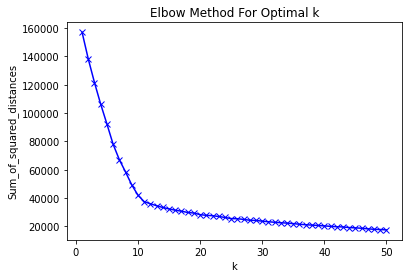

In [52]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [65]:
df_tweets_grouped["cluster"] = KMeans(n_clusters=10).fit_predict(df_tweets_grouped[["topic%d"%num for num in range(10)]])
df_tweets_grouped["cluster"].value_counts()

1    83985
4    59146
3    52788
5    52104
2    44650
7    44438
0    44237
8    40453
6    32916
9    28511
Name: cluster, dtype: int64

In [66]:
print(df_tweets_grouped.shape)
df_tweets_grouped.head()

(483228, 16)


,username,concat_text,concat_raw_text,tokens,lemma_tokens,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,cluster
0,1mikestreet1,trumps war critical race theory maybe importan...,Trump’s war on critical race theory is maybe t...,"[trumps, war, critical, race, theory, maybe, i...","[war, critical_race, theory, important, thing,...",0.000000,0.000000,0.000000,0.0,0.389846,0.000000,0.000000,0.000000,0.610154,0.000000,0
1,mulliganpete,typical sarah sanders dodging questions report...,Typical Sarah Sanders dodging questions. This ...,"[typical, sarah, sanders, dodging, questions, ...","[typical, sarah_sander, question, reporter, pl...",0.136498,0.171656,0.000000,0.0,0.691847,0.000000,0.000000,0.000000,0.000000,0.000000,8
2,Tom26058303,rumble episode address explosive ties billiona...,"Rumble — In this episode, I address the explos...","[rumble, episode, address, explosive, ties, bi...","[rumble, address, explosive, tie, billionaire,...",0.000000,0.195459,0.000000,0.0,0.000000,0.442998,0.031379,0.000000,0.134757,0.195407,3
3,adiinvincible25,liberal media joke loonies going gaga xi jinpi...,The US “liberal” media is a JOKE. Loonies goin...,"[liberal, media, joke, loonies, going, gaga, x...","[liberal, medium, joke_loonie, head_totalitari...",0.000000,0.000000,0.000000,0.0,0.000000,0.340498,0.000000,0.659502,0.000000,0.000000,4
4,Surya29011996,covid19 report 22nd september new positive cas...,Covid-19 Report For 22nd September\n\nNew Posi...,"[covid19, report, 22nd, september, new, positi...","[new, positive, case, quarantine, local, conta...",0.057294,0.025378,0.115624,0.0,0.162637,0.028436,0.050983,0.559647,0.000000,0.000000,4


In [68]:
silhouette_score(df_tweets_grouped[["topic%d"%num for num in range(10)]], df_tweets_grouped["cluster"], sample_size=40_000, random_state=42)

0.3957639431552358

In [69]:
df_tweets_grouped["concat_raw_text"].isna().sum()

0

### Testing Tool: Based on a given tweet document, recommend top 5 usernames with similar tweet documents.

In [70]:
data = df_tweets_grouped
print(data.shape)
data.head()

(483228, 16)


,username,concat_text,concat_raw_text,tokens,lemma_tokens,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,cluster
0,1mikestreet1,trumps war critical race theory maybe importan...,Trump’s war on critical race theory is maybe t...,"[trumps, war, critical, race, theory, maybe, i...","[war, critical_race, theory, important, thing,...",0.000000,0.000000,0.000000,0.0,0.389846,0.000000,0.000000,0.000000,0.610154,0.000000,0
1,mulliganpete,typical sarah sanders dodging questions report...,Typical Sarah Sanders dodging questions. This ...,"[typical, sarah, sanders, dodging, questions, ...","[typical, sarah_sander, question, reporter, pl...",0.136498,0.171656,0.000000,0.0,0.691847,0.000000,0.000000,0.000000,0.000000,0.000000,8
2,Tom26058303,rumble episode address explosive ties billiona...,"Rumble — In this episode, I address the explos...","[rumble, episode, address, explosive, ties, bi...","[rumble, address, explosive, tie, billionaire,...",0.000000,0.195459,0.000000,0.0,0.000000,0.442998,0.031379,0.000000,0.134757,0.195407,3
3,adiinvincible25,liberal media joke loonies going gaga xi jinpi...,The US “liberal” media is a JOKE. Loonies goin...,"[liberal, media, joke, loonies, going, gaga, x...","[liberal, medium, joke_loonie, head_totalitari...",0.000000,0.000000,0.000000,0.0,0.000000,0.340498,0.000000,0.659502,0.000000,0.000000,4
4,Surya29011996,covid19 report 22nd september new positive cas...,Covid-19 Report For 22nd September\n\nNew Posi...,"[covid19, report, 22nd, september, new, positi...","[new, positive, case, quarantine, local, conta...",0.057294,0.025378,0.115624,0.0,0.162637,0.028436,0.050983,0.559647,0.000000,0.000000,4


In [25]:
# test - 1: Please wear masks, observe social distancing, and wash hands regularly to keep yourself and your loved ones safe from the
# deadly covid19. Working from home this summer! Trying to be productive this quarantine season

# test - 2: I'm a proud democrat, supporting Joe Biden for this presidential election. We will win by a landslide!! #Biden2020 The
# democrats are winning! Biden is ahead on the national polls. Joe Biden is the kind of president we need to recover from this crisis.
# We cannot recover until there is a change of power in this country!

doc = input("USER'S TWEET DOCUMENT: ")
cleaned_doc = remove_stopwords(doc)
lemma_doc = lemmatization([cleaned_doc.split(" ")])
bow_vector = loaded_dictionary.doc2bow(lemma_doc[0])
topic_scores = [0 for _ in range(10)]
for index, score in loaded_lda.get_document_topics(bow_vector):
    topic_scores[index] = score
cluster = kmeans.predict([topic_scores])[0]


queue = PriorityQueue()
test_point = np.array(topic_scores)
for index, row in data[data["cluster"] == cluster].iterrows():
    point = row[["topic%s"%i for i in range(10)]].values
    queue.put((np.linalg.norm(test_point-point), index))

printmd("\n**LOOK AT WHAT OTHERS TWEETED ON SIMILAR TOPICS:**")
for i in range(5):
    user, text = data.loc[queue.get()[1]][["username", "concat_raw_text"]].values
    printmd("\n**@"+user+"** tweeted:")
    print(text)


USER'S TWEET DOCUMENT: I'm a proud democrat, supporting Joe Biden for this presidential election. We will win by a landslide!! #Biden2020 The democrats are winning! Biden is ahead on the national polls. Joe Biden is the kind of president we need to recover from this crisis. We cannot recover until there is a change of power in this country!



**LOOK AT WHAT OTHERS TWEETED ON SIMILAR TOPICS:**


**@mojoandjasper** tweeted:

This is NOT FUCKING OKAY.
THIS is why we need to show up this November.
We can’t give up. 
For Breonna. 
Demand change and vote out those who won’t allow it. https://t.co/XEInmFBwQV
Michelle and I hope that the President, First Lady, and all those affected by the coronavirus around the country are getting the care they need and are on the path to a speedy recovery.



**@Adequate_Scott** tweeted:

There is no way out of ~all this~ without truly grappling with the malevolence and rot of the leaders in both sides. That's not handwaving Trump. This laser like focus on Trump, and the accompanying "we'll have time to argue about Reparations after Biden wins" is the handwave.



**@KayS57** tweeted:

Biden responds to Trump blaming him for the lack of a national mask mandate by correctly pointing out that Trump is in fact the president https://t.co/0aLTPGHEUK 04
#VoteEarly
Anti-Abortion Zealots Demand a Vote to Fill Ginsburg's Seat | By: Ed Kilgore https://t.co/hRV96jzsuy
I think the Bush brothers, George &amp; Jeb, should endorse Joe Biden ASAP
Trump steals from kids-cancer charities. You don’t think he’ll try to steal this election?
BREAKING: Barack Obama will host two Biden campaign fundraisers with Kamala Harris next Friday.



**@KatneaB** tweeted:

No Wisconsin absentee ballots were found in mail discovered in a ditch in the Fox Valley last week, the state's top election official said. The White House has been pushing conspiracies about voter fraud based on this discovery. https://t.co/Z2wuXdzSeJ



**@pmramani** tweeted:

No Wisconsin absentee ballots were found in mail discovered in a ditch in the Fox Valley last week, the state's top election official said. The White House has been pushing conspiracies about voter fraud based on this discovery. https://t.co/Z2wuXdzSeJ
